## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [1]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


In [2]:
reviews

,0
0,bromwell high is a cartoon comedy . it ran at ...
1,story of a man who has unnatural feelings for ...
2,homelessness or houselessness as george carli...
3,airport starts as a brand new luxury pla...
4,brilliant over acting by lesley ann warren . ...
...,...
24995,i saw descent last night at the stockholm fi...
24996,a christmas together actually came before my t...
24997,some films that you pick up for a pound turn o...
24998,working class romantic drama from director ma...


**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. 

In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_, X_test, Y_, Y_test = train_test_split(reviews, Y, train_size=0.8, random_state=504)
X_train, X_validate, y_train, y_validate = train_test_split(X_, Y_, train_size=0.8, random_state=504)

print(X_train.shape, X_validate.shape, X_test.shape)

(16000, 1) (4000, 1) (5000, 1)


Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

The Bag-of-Words (BoW) representation allow us to transform the text data into a numerical format that can be used by machine learning algorithms.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a Bag-of-Words representation
vectorizer = CountVectorizer(max_features=10000)
X_train_bow = vectorizer.fit_transform(X_train[0].astype(str))
X_val_bow = vectorizer.transform(X_validate[0].astype(str))
X_test_bow = vectorizer.transform(X_test[0].astype(str))


In [5]:
print(X_train_bow.shape)

(16000, 10000)


**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [6]:
feature_names = vectorizer.get_feature_names_out()
bow_shape = X_train_bow.shape

single_review_index = 123  # Choosing the first review
single_review_text = X_train.iloc[single_review_index].values[0]
single_review_representation = X_train_bow[single_review_index].toarray()

# Words and their counts in the single review
nonzero_indices = single_review_representation.nonzero()[1]
words_in_review = [feature_names[i] for i in nonzero_indices]
word_counts_in_review = single_review_representation[0, nonzero_indices]

# Results
single_review_summary = {
    "Original Review": single_review_text,
    "Words in Review": words_in_review,
    "Word Counts": word_counts_in_review.tolist(),
    "BoW Row Representation": single_review_representation.tolist()
}

bow_shape, single_review_summary

((16000, 10000),
 {'Original Review': 'released as zentropa in north america to avoid confusion with agniezska holland  s own holocaust film europa europa  this third theatrical feature by a filmmaker who never ceases to surprise  inspire or downright shock is a bizarre  nostalgic  elaborate film about a naive american in germany shortly following the end of wwii . the american  named leo  doesn  t fully get what he  s doing there . he has come to take part in fixing up the country since  in his mind  it  s about time germany was shown some charity . no matter how that sounds  he is not a nazi sympathizer or so much as especially pro  german  merely mixed up . his uncle  who works on the railroad  gets leo a job as a helmsman on a sleeping car  and he is increasingly enmeshed in a vortex of     germany  s horrors and enigmas .  br    br   this progression starts when leo  played rather memorably by the calm yet restless actor jean  marc barr  meets a sultry heiress on the train played 

In [7]:
X = vectorizer.fit_transform(reviews[0]).toarray()
df_bow_sklearn = pd.DataFrame(X,columns=vectorizer.get_feature_names_out())


In [8]:
print('Most frequent words: ')
df_bow_sklearn.sum().sort_values(ascending=False).head(20)

Most frequent words: 


the      336713
and      164107
of       145864
to       135720
is       107328
br       101872
it        96352
in        93968
this      76000
that      73245
was       48208
as        46933
for       44343
with      44125
movie     44039
but       42603
film      40155
you       34230
on        34200
not       30626
dtype: int64

Single word: each word is represented as a column index in the BOW matrix. The column value is the word count in the respective review. If the word is not in the review, the value is 0.

Whole review: each review is a row vector of word counts for all 10 000 features. Most values will be 0, indicating that the majority of the words in the vocabulary is not present in a single review.

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [9]:
# Convert sparse matrices to dense format
X_train_bow_dense = X_train_bow.toarray()
X_val_bow_dense = X_val_bow.toarray()
X_test_bow_dense = X_test_bow.toarray()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input

model = tf.keras.Sequential([
    Input(shape=(10000,)),  # Define input layer
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')     # binary classification --> sigmoid & 1 output neuron 

])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

We define a sequential model with:
An input layer of size 10,000 (the number of features).
A hidden layer with 128 neurons and ReLU activation.
An output layer with a single neuron and sigmoid activation for binary classification.
The model is compiled with the Adam optimizer and binary crossentropy loss function.

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# fit the model using the dense matrices
history = model.fit(X_train_bow_dense, y_train, epochs=10, validation_data=(X_val_bow_dense, y_validate) , callbacks=[early_stop])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8135 - loss: 0.4340 - val_accuracy: 0.8775 - val_loss: 0.3252
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9374 - loss: 0.1587 - val_accuracy: 0.8720 - val_loss: 0.3539
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9707 - loss: 0.0788 - val_accuracy: 0.8655 - val_loss: 0.4979
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9835 - loss: 0.0452 - val_accuracy: 0.8685 - val_loss: 0.4382
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9886 - loss: 0.0319 - val_accuracy: 0.8658 - val_loss: 0.6957
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9946 - loss: 0.0166 - val_accuracy: 0.8705 - val_loss: 0.8674
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9944 - loss: 0.0202 - val_accuracy: 0.8662 - val_loss: 0.9626
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9930 - loss: 0.0216 - val_accu

In [12]:
import matplotlib.pyplot as plt
# Extract loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)



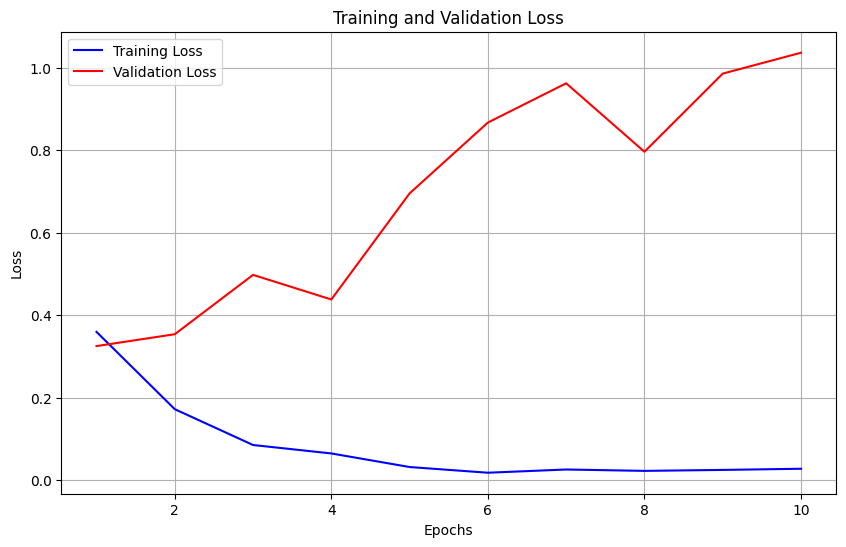

In [13]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

**(d)** Test your sentiment-classifier on the test set.

In [14]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_bow_dense, Y_test)
print(f'Test accuracy: {test_accuracy}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8710 - loss: 0.3068
Test accuracy: 0.8726000189781189


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      2503
           1       0.84      0.93      0.88      2497

    accuracy                           0.87      5000
   macro avg       0.88      0.87      0.87      5000
weighted avg       0.88      0.87      0.87      5000



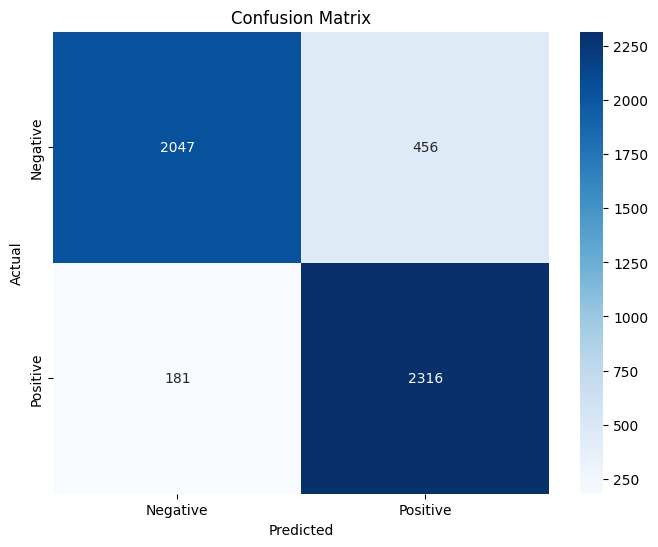

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_pred = model.predict(X_test_bow_dense)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Print classification report
print(classification_report(Y_test, y_pred_classes))

# Plot confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [16]:
import numpy as np

# Step 1: Write your sentences
test_sentences = [
    "Interesting first half an hour, but way too long and boring",
    "Great, highly recommend it",
    "I would watch it again!",
    "Trash, I don't know who financed this",
    "I fell asleep 3 times"
]

# Step 2: Preprocess the sentences using the same vectorizer
test_sentences_bow = vectorizer.transform(test_sentences)

# Step 3: Make predictions
predictions = model.predict(test_sentences_bow.toarray())

# Step 4: Interpret the predictions
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary classes

# Output the results
for sentence, pred in zip(test_sentences, predicted_classes):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f'Sentence: "{sentence}"\nPredicted Sentiment: {sentiment}\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sentence: "Interesting first half an hour, but way too long and boring"
Predicted Sentiment: Positive

Sentence: "Great, highly recommend it"
Predicted Sentiment: Negative

Sentence: "I would watch it again!"
Predicted Sentiment: Negative

Sentence: "Trash, I don't know who financed this"
Predicted Sentiment: Negative

Sentence: "I fell asleep 3 times"
Predicted Sentiment: Positive

